# Amplifier Non Linearity

The transmitter/receiver chain in any wireless system has many components These components are arranged in a cascade and perform operations one after another, and hence the term "chain". A simplified version of the transmit chain is shown below:

<img src="rf_transmit_chain.png"/>

A simplified version of the receiver chain is shown below:
<img src="rf_receive_chain.png"/>

In this post, our component of interest are amplifiers. The Power Amplifier (PA) is used to boost the power of the transmit signal at the output of the upconversion. This is how the transmitted signal is raised to the required power level for day-to-day applications. PAs can be found in almost every device, from phones and routers to commercial LTE basestations. While the PAs on phones and routers may be integrated into the PCB itself, the PAs on LTE basestations provide close to 30 dB (1000 times) gain and are separate modules themselves. The Low Noise Amplifier (LNA) is the first block after the antenna in a receive chain. The LNA boosts the power of the received signal while maintaining a very low noise figure. It helps ensure that even weak signals can be reliably processed and detected. One common tradeoff among all amplifiers is between their efficiency (power efficiency) and distortion introduced in the signal. We look at how amplifier induced non-linearity affects the signal and some methods to mitigate this distortion.

## Effects of Non Linearity

In this section, we'll look at how non linearity in an analog component affects a signal that it processes. If we consider memoryless systems, we can approximately model their input/output characteristics as:

$$
y(t)\approx { \alpha  }_{ 1 }x(t)+{ \alpha  }_{ 2 }{ x }^{ 2 }(t)+{ \alpha  }_{ 3 }{ x }^{ 3 }(t)
$$

While the above is a reasonable approximation in many systems, it is not true in general. Systems with memory elements (dynamic non-linearity) or significant higher order nonlinear terms must be treated differently. In this post, dynamic non-linearities and their representation using Volterra series will not be discussed (2.7 in RF Microelectronics).

In [113]:
# The below is a command to force the ipynb to plot inline instead of popping a window
%matplotlib inline
# numerical python "numpy" library
import numpy as np
# plotting library
import matplotlib.pyplot as plt   

# Let us define a function in python which takes an input signal and computes
# the output of a nonlinear block according to the equation mentioned above
def non_linear_transform(x_in,coeff_vec = np.array([1.0,1.0,1.0])):
    # x_in is the input vector and is a np.array()
    # coeff_vec is the coefficient of each nonlinear component. The default value is 1.0,1.0,1.0
    y_out = coeff_vec[0]*x_in + coeff_vec[1]*(x_in*x_in) + coeff_vec[2]*(x_in*x_in*x_in) 
    return y_out

### Harmonic Distortion

If we use $x(t) = Acos(\omega t)$ in our mathematical model for non-linearity and then simplify the resulting expression, we get (equations courtesy RF Microelectronics):

<img src="razavi_1.png"/>

We see that the output contains signals whose frequency components are integer multiples ("harmonics") of the input frequency. The first term in the equation above is a DC component arising from second-order nonlinearity, the second term is called the fundamental harmonic, the third is the second harmonic and the fourth is the third harmonic. In many RF circuits, presence of harmonic distortion is an unimportant indicator of the effect of nonlinearity since higher harmonics are usually heavily suppressed due to the circuits inherent bandwidth. For example, an amplifier of a WiFi chip operates at 2.4 GHz and the second harmonic will be at 4.8 GHz and can be suppressed if the circuit is designed to have a small bandwidth.


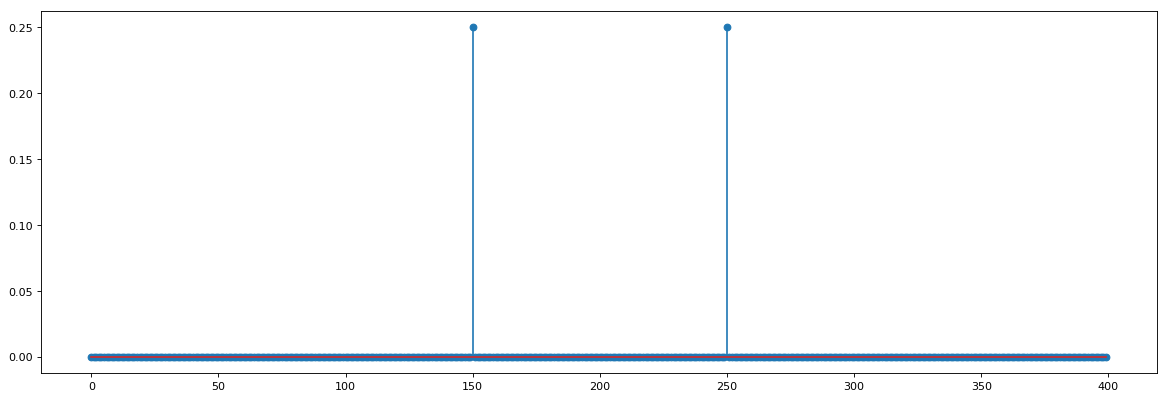

In [73]:
# Center frequency of sine signal
f_c = 250;
# Sampling interval in seconds
t_step = 0.0005
# Sampling Frequency (Hz)
f_s = 1/t_step;
# Sampling time vector 0 s - 0.2 s in steps of t_step
t = np.arange(0,0.2,t_step);
# Length of signal (for FFT normalisation)
n = len(t)
# Frequency vector after FFT
f_vec = np.arange(-f_s/2,f_s/2,f_s/n)
# Sine signal
x = np.cos(2*np.pi*f_c*t);
# Taking FFT, shifting it and scaling it by n
X = np.fft.fftshift(np.fft.fft(x))/n;

# Setting figure dimensions
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

# Plotting figure
plt.stem(f_vec,np.abs(X*X));
plt.title('A linear receiver');
plt.ylabel('Magnitude');
plt.xlabel('Frequency');

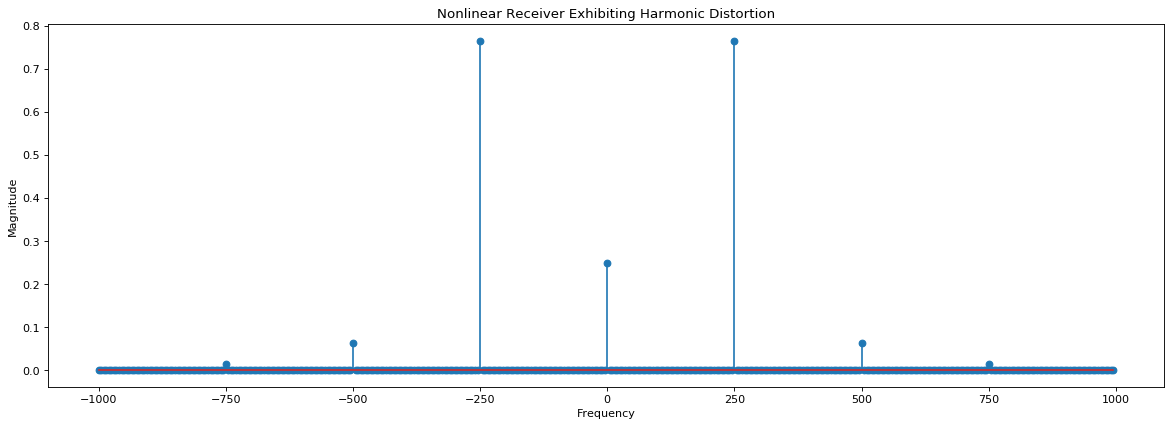

In [114]:
coeff_vec = np.array([1.0,1.0,1.0])
x_1 = x
x_o_1 = non_linear_transform(x,coeff_vec)

# Taking FFT, shifting it and scaling it by n
X_o_1 = np.fft.fftshift(np.fft.fft(x_o_1))/n;

# Setting figure dimensions
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

# Plotting figure
plt.stem(f_vec,np.abs(X_o_1*X_o_1));
plt.title('Nonlinear Receiver Exhibiting Harmonic Distortion');
plt.ylabel('Magnitude');
plt.xlabel('Frequency');

### Gain Compression

In the equation discussed in the previous subsection, the amplitude gain experienced by $Acos(\omega t)$  is ${ \alpha  }_{ 1 }A+3{ \alpha  }_{ 3 }{ A }^{ 2 } / 4 $. Let us now look at the signs of $\alpha_1$ and $\alpha_3$. If $\alpha_1\alpha_3 > 0$, then the cube term becomes dominant for sufficiently large amplitudes of $x(t)$. This causes a surge in gain as the amplitude of $x$ increases (gain expansion). However, if $\alpha_1\alpha_3 < 0$, then the $\alpha_3x^3$ "bends" the gain characteristic for a sufficiently large $x$. This reduces the gain as input amplitude increases, and is called gain compression. Most RF circuits of interest, including PAs are compressive. (Figure courtesy RF Microelectronics) 

<img src="gain_compression.png"/>

In the above figure, $A_{in}$ and $A_{out}$ are the input and output peak-to-peak amplitudes respectively. Notice how the slope of the gain changes for a sufficiently large input amplitude. The value of $A_{in}$ for which $A_{out}$ is 1 dB below the ideally expected value is called the 1-dB compression point or $P_{1dB}$. Compression effects need to be understood and accounted for in transmitters and receivers.


Why do we need to worry about gain compression? Two major reasons:

1. **Amplitude Distortion** : For signals which are amplitude modulated, gain compression causes an amplitude limiting effect that leads to loss of information encoded. For signals which are solely frequency modulated however, this effect does not manifest significantly as information in encoded in frequency and is resilient to amplitude limiting effects.
2. **Desensitisazion** : This phenomenon occurs when the signal of interest is received along with a high power interferer in a nearby channel within the amplifier bandwidth. The high power of the interferer causes large swings in the input of the amplifier and makes it go into the gain compression area. Therefore, the signal of interest sees lower gain. This lowers the SNR at the amplifier output and affects all kinds of signals, even if they contain no amplitude information.




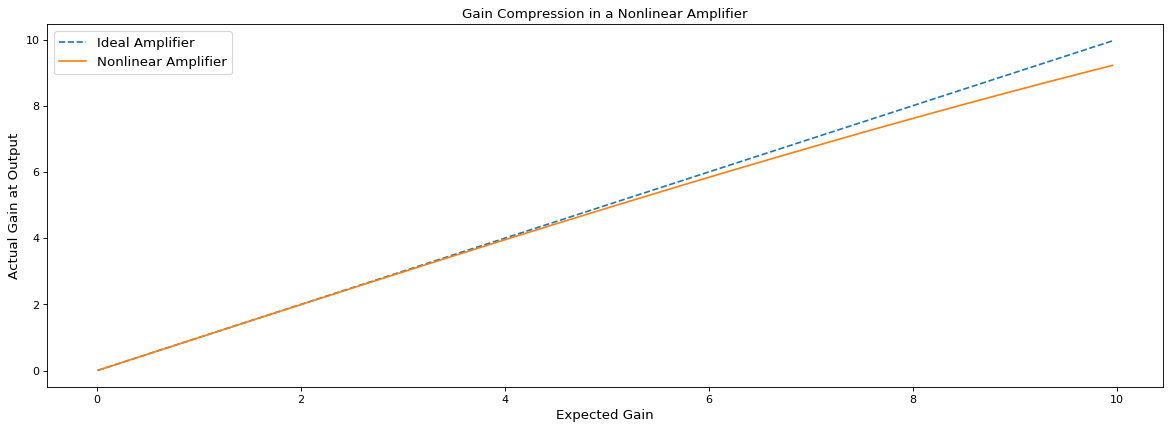

In [298]:
# Gain Compression example
coeff_vec = np.array([1,0.003,-0.001])
x_o_1 = non_linear_transform(x_1,coeff_vec)

# We test the amplifier by setting gains 
gain_range = np.arange(0.01,10,0.05);
gain_range_n = len(gain_range);

gain_observed_vec = np.zeros((gain_range_n,1))
i=0
for gain in gain_range:
    x_o_1 = non_linear_transform(gain*x_1,coeff_vec)
    # Taking FFT, shifting it and scaling it by n
    X_o_1 = np.fft.fftshift(np.fft.fft(x_o_1))/n;
    effective_gain = np.sqrt(4*np.abs(X_o_1[250]*X_o_1[250]))
    gain_observed_vec[i] = effective_gain
    i = i+1
    
# Setting figure dimensions
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(gain_range,gain_range,'--');
plt.plot(gain_range,gain_observed_vec,'-');

plt.title('Gain Compression in a Nonlinear Amplifier',fontsize='large');
plt.xlabel('Expected Gain',fontsize='large');
plt.ylabel('Actual Gain at Output',fontsize='large');
plt.legend(['Ideal Amplifier','Nonlinear Amplifier'],fontsize='large');

### Intermodulation

Till now, we considered the input-output relationship of a single signal or a case where a desired signal was accompanied by a large interferer. A related scenario of interest is one where a desired signal is received along with _two_ interferers. In such a scenario, certain effects manifest which don't reveal themselves in a gain compression or harmonic distortion test. To understand how intermodulation occurs, assume that $x(t)={ A }_{ 1 }cos({ \omega  }_{ 1 }t)+{ A }_{ 2 }cos({ \omega  }_{ 2 }t)$ in this subsection. We then have (all equations courtesy of RF Microelectronics):
<img src="razavi_2.png"/>
If we expand the RHS, discard the DC terms, harmonics and components at $\omega_1\pm\omega_2$, we obtain the following "intermodulation products":
<img src="razavi_3.png"/>
and these fundamental harmonics:
<img src="razavi_4.png"/>
Among the intermodulation products, the third order products at $2\omega_1-\omega_2$ and $2\omega_2-\omega_1$ are of special significance, because if $\omega_1$ and $\omega_2$ are close to each other, then these products appear in the vicinity. Let's look at what that means in practical use cases:


Suppose an antenna (or any receiver) receives a desired signal at $\omega_0$ along with strong interferers at  $\omega_1$ and $\omega_2$. This combination will directly go into the amplifier (low noise) that sits after the antenna in the receive chain. In case the interferers happen to satisfy the condition $2\omega_1-\omega_2 = \omega_0$, then the intermodulation products will corrupt the desired signal by falling onto the same frequency as the desired sigal.

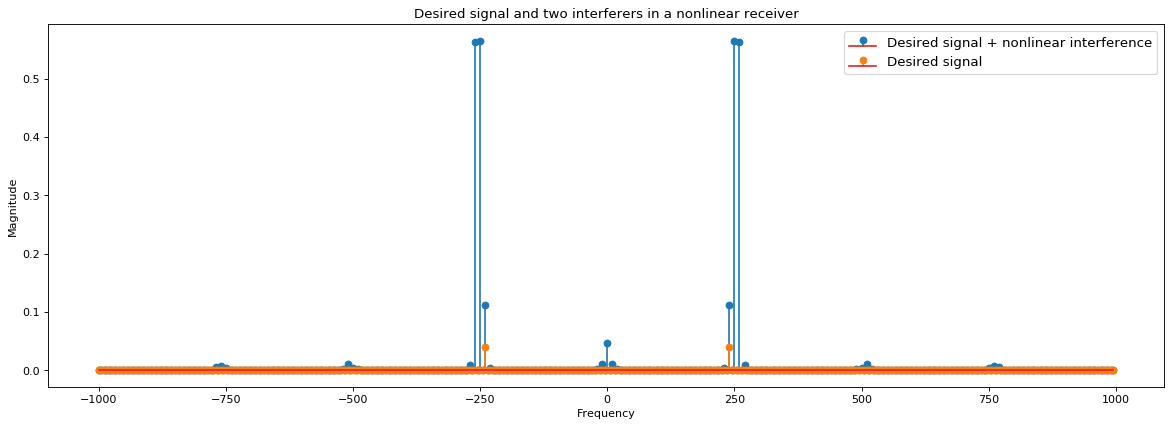

In [299]:
# Intermodulation example.
# Pay attention to the coefficients and the relative powers
# of signals
coeff_vec = np.array([1,0.2,0.2])
# Creating a signal that has a frequency close to x_1
x_2 = np.cos(2*np.pi*(f_c+10)*t);

# The desired received signal
x_d = 0.4*np.sin(2*np.pi*(f_c-10)*t);

# Simulating two interferers and a desired signal superposed
x_3 = x_1 + x_2 + x_d

x_3_o = non_linear_transform(x_3,coeff_vec)

# Taking FFT, shifting it and scaling it by n
X_3_o = np.fft.fftshift(np.fft.fft(x_3_o))/n
# FFT of the desired signal
X_d = np.fft.fftshift(np.fft.fft(x_d))/n

# Setting figure dimensions
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

# Plotting the full figure
plt.stem(f_vec,np.abs(X_3_o*X_3_o),linefmt='C0-',markerfmt='C0o');
plt.stem(f_vec,np.abs(X_d*X_d),linefmt='C1-',markerfmt='C1o');
plt.legend(['Desired signal + nonlinear interference','Desired signal'],fontsize='large');
plt.title('Desired signal and two interferers in a nonlinear receiver');
plt.ylabel('Magnitude');
plt.xlabel('Frequency');

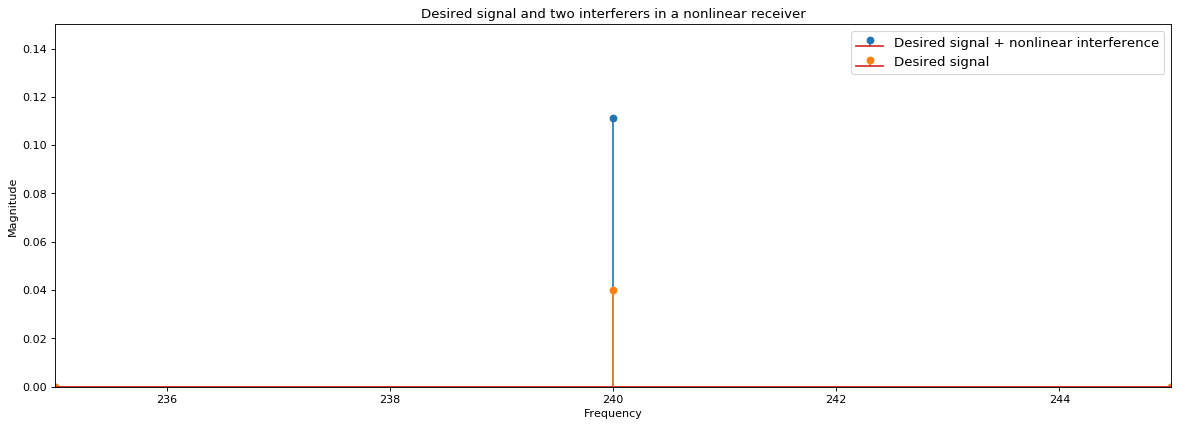

In [300]:
# Setting figure dimensions
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

# Plotting figure (zoomed in)
plt.stem(f_vec,np.abs(X_3_o*X_3_o),linefmt='C0-',markerfmt='C0o');
plt.stem(f_vec,np.abs(X_d*X_d),linefmt='C1-',markerfmt='C1o');
plt.legend(['Desired signal + nonlinear interference','Desired signal'],fontsize='large');
plt.xlim([235,245]);
plt.title('Desired signal and two interferers in a nonlinear receiver');
plt.ylabel('Magnitude');
plt.xlabel('Frequency');
plt.ylim([0.0,0.15]);

In the above python example, two nearby interferers completely swamp the received signal. Below is a frequency domain transform if a perfectly linear receiver was used, the interferers do not bleed into the desired signal at all.

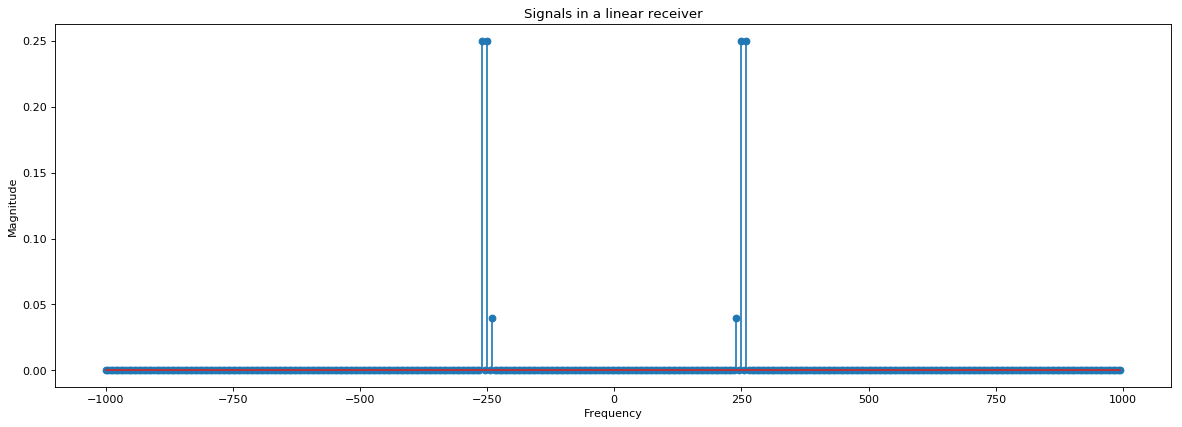

In [301]:
# Simulating two interferers and a desired signal superposed - linear
x_3 = x_1 + x_2 + x_d

# Taking FFT, shifting it and scaling it by n
X_3 = np.fft.fftshift(np.fft.fft(x_3))/n

# Setting figure dimensions
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

# Plotting the full figure
plt.stem(f_vec,np.abs(X_3*X_3),linefmt='C0-',markerfmt='C0o');
plt.title('Signals in a linear receiver');
plt.ylabel('Magnitude');
plt.xlabel('Frequency');

## Linearization Techniques

Many linearization techniques are employed to mitigate the effects of nonlinearities in transmit and receive chains. There are many RF design techniques that have been developed and deployed in amplifiers that aim to reduce nonlinear characteristics. Methods such as feedforward, Cartesian feedback, envelope feedback and predistortion are treated extensively in the literature. In this section, we'll solely focus on predistortion.

### Predistortion

This method reduces the effect of nonlinearity by pre-emptively distorting the signal in a manner that the nonlinear system restores the signal to the desired form. In other words, predistorion involves distorting the signal in the exact inverse of how the nonlinear block shall distort it, effectively cancelling the nonlinear distortion. Note that such a technique is employed in the transmitter chain.

A block diagram of digital predistortion (DPD) is illustrated below:
<img src="predistortion.png"/>

Predistortion is not trivial to implement. The nonlinear attributes of the amplifier changes in action due to temperature, process and load impedance (among others) and therefore, predistorion techniques need to track these changes. Added to this, no amount of predistortion can correct for abrupt nonlinear responses that may occur in real life scenarios. That being said, digital predistortion is an effective and widely used technique.

In the below python example, we use Least Squares method to estimate a linear filter that will best correct for the nonlinearity.

In [302]:
# Digital Pre-Distortion Example

# In this example, we'll create a 4 tap linear filter that
# minimises the least square error between the x_1_o
# and x_1

# Our transmit signal x_1 with no distortion
x_1 = x;
# Coefficients for the nonlinearity
coeff_vec = np.array([1,0.003,-0.001])
# Nonlinear output x_1_o
x_1_o = non_linear_transform(x_1,coeff_vec);

# We now find the filter that returns x_1 when it is
# convolved with x_1_o

# Splitting x_1_o for Least Squares estimate
as_strided = np.lib.stride_tricks.as_strided
A_mat = as_strided(x_1_o, (396,4), x_1_o.strides*2)
# Least squares estimate
w = np.linalg.lstsq(A_mat,x_1[0:396],rcond=None)
# Normalised filter taps
dpd_filt = w[0]/np.abs(w[0])
# x_dpd is the output of the digital predistortion filter
x_dpd = np.convolve(x_1,dpd_filt,mode='same')

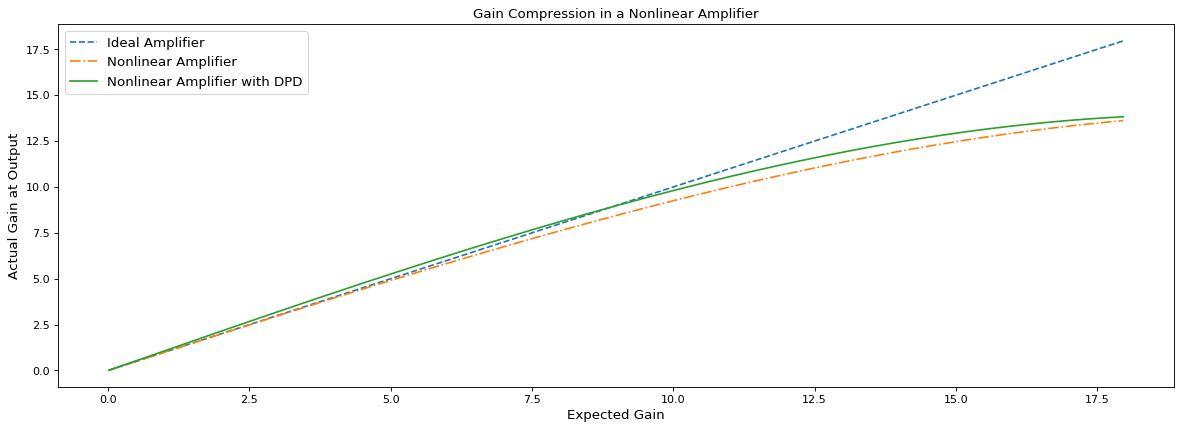

In [303]:
# We now test the outcome of DPD on the Gain compression test
# We test the amplifier by setting gains 
gain_range = np.arange(0.01,18,0.05);
gain_range_n = len(gain_range);

# Observed gain without DPD
gain_observed_vec = np.zeros((gain_range_n,1))
# Observed gain with DPD
gain_observed_vec_dpd = np.zeros((gain_range_n,1))
i=0
for gain in gain_range:
    # Finding effective gain without DPD
    x_1_o = non_linear_transform(gain*x_1,coeff_vec)
    # Taking FFT, shifting it and scaling it by n
    X_1_o = np.fft.fftshift(np.fft.fft(x_1_o))/n;
    effective_gain = np.sqrt(4*np.abs(X_1_o[250]*X_1_o[250]))
    gain_observed_vec[i] = effective_gain
    
    # Finding effective gain with DPD
    x_dpd_o = non_linear_transform(gain*x_dpd,coeff_vec)
    # Taking FFT, shifting it and scaling it by n
    X_dpd_o = np.fft.fftshift(np.fft.fft(x_dpd_o))/n;
    effective_gain = np.sqrt(4*np.abs(X_dpd_o[250]*X_dpd_o[250]))
    gain_observed_vec_dpd[i] = effective_gain

    i = i+1
    
# Setting figure dimensions
fig = plt.figure(figsize=(18, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(gain_range,gain_range,'--');
plt.plot(gain_range,gain_observed_vec,'-.');
plt.plot(gain_range,gain_observed_vec_dpd,'-');

plt.title('Gain Compression in a Nonlinear Amplifier',fontsize='large');
plt.xlabel('Expected Gain',fontsize='large');
plt.ylabel('Actual Gain at Output',fontsize='large');
plt.legend(['Ideal Amplifier','Nonlinear Amplifier','Nonlinear Amplifier with DPD'],fontsize='large');

We can see in the above simulation that DPD has some positive effects. The green line is more closer to the ideal amplifier scenario as compared to the yellow line. This is especially true at higher gains. DPD actually improves the effective $P_{1dB}$. However, note that DPD makes the gain go above ideal values at lower gain settings. This could be attributed to the fact that in our algorithm to compute DPD method, we assumed linear taps and that too only 4. More complex methods of DPD employ adaptive algorithms with linear and nonlinear taps in order to more closely mimic and reverse the effect of amplifier nonlinearity.

## Exercises

### Q1 

The definition of $P_{1dB}$ is outlined in the gain compression section. With the code snippet for plotting the gain compression as reference, add your own code to compute the $P_{1dB}$ value of our amplifier model with ``coeff_vec = np.array([1,0.003,-0.001])``.

In [304]:
# Q1 Code

### Q2

Using the code for DPD as reference, compute the value of $P_{1dB}$ for the digitally predistorted signal. Do you think you can compute a DPD filter/algorithm that does better than this? If so, how?

In [305]:
# Q2 Code

### Q3

Use an appropriate filter to remove (relative power difference > 50 dB) harmonic distortions at the output of a nonlinear amplifier model with ``coeff_vec = np.array([1,0.3,-0.1])``. 

In [306]:
# Q3 Code

## References

1. Behzad Razavi, RF Microelectronics, 1997
2. Numpy Official Website: https://www.numpy.org/